# Coulomb and Lennard-Jones potential

In [12]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import particlesim.api
import particlesim.test_total_potential as test
import particlesim.total_potential as pot
import time
import particlesim.helpers_for_tests as create
from mpl_toolkits.mplot3d import Axes3D

## Potential Calculation

### Total Potential

* Total Potential is used as a wrapper class
* Automatic estimation of cutoff-parameters






### Shortrange Potential

* With neighbouring:
    - Inner loop is replaced by numpy arrays
* Without neighbouring (r_cutoff almost 0.5 box_size):
    - Distance Matrix calculated in Cython



In [27]:
def time_short():
    shortrange_time_total = 0
    for i in range(100):
        system_conf = create.create_system_configuration(100, 10)
        potential = pot.TotalPotential(system_conf)

        start = time.time()
        potential.shortrange_energy(system_conf.xyz)
        shortrange_time_total += time.time() - start
    return shortrange_time_total / 100
print("Time for short-range potential calculation = ", time_short(), "s")

Time for short-range potential calculation =  0.019900262355804443 s


### Longrange Potential

* K-Vectors are calculated in Cython
* All loops are replaced by numpy arrays

In [29]:
def time_long():
    longrange_time_total = 0
    for i in range(100):
        system_conf = create.create_system_configuration(100, 10)
        potential = pot.TotalPotential(system_conf)

        start = time.time()
        potential.longrange_energy(system_conf.xyz)
        longrange_time_total += time.time() - start
    return longrange_time_total / 100
print("Time for long-range potential calculation = ", time_long(), "s")

Time for long-range potential calculation =  0.0015631580352783202 s


In [17]:
def particle_config(box_size = 10.2, charges= 1, sigma = 1.0, epsilon = 1.0, r_lim = 0.95, lennard_jones = True, coulomb = False):
    particle_1 = [0.,0,0]
    particle_2 = [box_size - r_lim,0,0]
    particle_positions = np.array([particle_1, particle_2])
    system_configuration = particlesim.api.SystemConfiguration(particle_positions,charges=charges, sigmas = sigma, epsilons = epsilon,
                                                               box_size = box_size)
    distance, pot = [], []
    while particle_positions[0][0] <= particle_positions[1][0]-r_lim:
        particle_positions[0][0] += 0.05
        r = np.linalg.norm(particle_positions[0] - particle_positions[1])
        if r > box_size/2:
            r -= box_size
        distance.append(r)
        pot.append(system_configuration.potential(xyz_trial = particle_positions,
                                                  lennard_jones=lennard_jones, coulomb = coulomb))
 
    distance = distance[int(len(distance)/2):]+distance[:int(len(distance)/2)]
    pot = pot[int(len(pot)/2):] + pot[:int(len(pot)/2)]
    return distance[::-1], pot[::-1]

### Parameter for Na+ and Cl-

In [3]:
sigma_na = 1.21496
epsilon_na = 0.0469
q_na = +1.0

sigma_cl = 2.02234 
epsilon_cl = 0.15
q_cl = -1.0

sigmas=[sigma_na, sigma_cl]
epsilons = [epsilon_na, epsilon_cl]
charges = [q_na, q_cl]

### Calculate Lennard Jones Potential of Na+ and Cl-

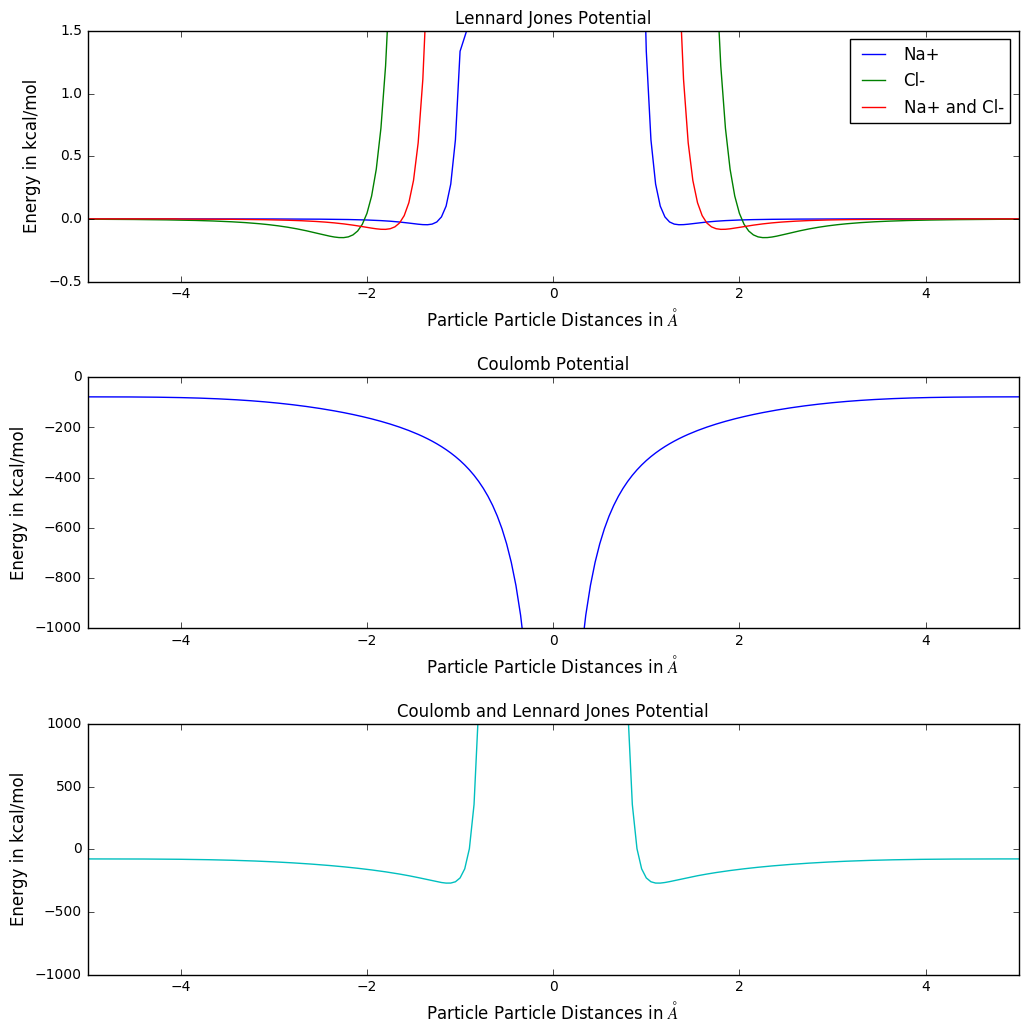

In [7]:
distance_na, pot_na = particle_config(sigma=sigma_na, epsilon=epsilon_na, lennard_jones=True, coulomb=False)
distance_cl, pot_cl = particle_config(sigma=sigma_cl, epsilon=epsilon_cl, lennard_jones=True, coulomb=False)
distance_mix, pot_mix = particle_config(sigma=sigmas,epsilon=epsilons, lennard_jones=True, coulomb=False)


distance_coulomb, pot_coulomb = particle_config(charges=charges, sigma=sigmas, epsilon=epsilons, r_lim=0.1,
                                                lennard_jones= False, coulomb=True)

distance_LJ_C, pot_LJ_C = particle_config(charges=charges, sigma=sigmas, epsilon=epsilons, r_lim=0.7,
                                                lennard_jones= True, coulomb=True)


fig, axes = plt.subplots(3,1, figsize=(10,10))
fig.tight_layout(h_pad=5)
axes[0].plot(distance_na,pot_na, label='Na+')
axes[0].plot(distance_cl,pot_cl, label='Cl-')
axes[0].plot(distance_mix,pot_mix, label='Na+ and Cl-')
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_xlim([-5,5])
axes[0].set_ylim([-0.5, 1.5])
axes[0].set_title(r"Lennard Jones Potential")
axes[0].set_xlabel(r"Particle Particle Distances in $\AA$", fontsize=12)
axes[0].set_ylabel(r"Energy in kcal/mol", fontsize=12)
axes[0].legend()

axes[1].plot(distance_coulomb, pot_coulomb, label='q_Na = +1.0, q_Cl = -1.0')
axes[1].set_xlabel(r"$r$", fontsize=15)
axes[1].set_xlim([-5,5])
axes[1].set_ylim([-1000, 0])
axes[1].set_title(r"Coulomb Potential")
axes[1].set_xlabel(r"Particle Particle Distances in $\AA$", fontsize=12)
axes[1].set_ylabel(r"Energy in kcal/mol", fontsize=12)

axes[2].plot(distance_LJ_C, pot_LJ_C,'c', label='q_Na = +1.0, q_Cl = -1.0')
axes[2].set_xlabel(r"$r$", fontsize=15)
axes[2].set_xlim([-5,5])
axes[2].set_ylim([-1000, 1000])
axes[2].set_title(r"Coulomb and Lennard Jones Potential")
axes[2].set_xlabel(r"Particle Particle Distances in $\AA$", fontsize=12)
axes[2].set_ylabel(r"Energy in kcal/mol", fontsize=12)

# Testing 

# Simple Test-System


(0, 10)

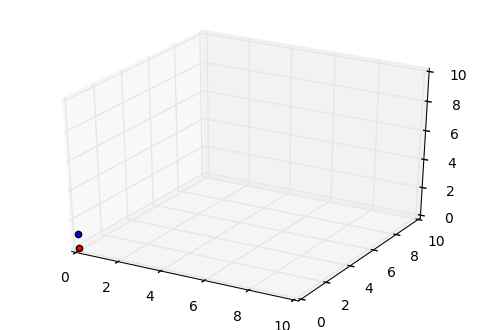

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([0], [0], [0] ,c='r')
ax.scatter([0], [0], [1] ,c='b')
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_zlim([0, 10])

## test_shortrange_ewald( )

$$E_s = \dfrac{1}{2} \cdot \sum_{n} \sum_{i=1}^{N} \sum_{j=1}^{N} \dfrac{q_i \cdot q_j}{\mid r_i - r_j + nL \mid} \cdot erfc \Big(\dfrac{\mid r_i - r_j + nL \mid}{\sqrt{2} \sigma}\Big)$$

$$E_s = -4 \cdot erfc\Big(\dfrac{1}{\sqrt{2}}\Big)$$

In [42]:
print(test.test_shortrange_ewald())

None


## test_lj_potential( )

$$\sum_{pairs i, j} 4 \epsilon_{ij} \bigg[\big(\dfrac{\sigma_{ij}}{\mid r_{ij} \mid}\big)^{12} - \big(\dfrac{\sigma_{ij}}{\mid r_{ij} \mid}\big)^{6} \bigg]$$

$$ 4 \epsilon_{NaCl} \bigg[\big(\sigma_{NaCl}\big)^{12} - \big(\sigma_{NaCl}\big)^{6} \bigg]$$

In [43]:
print(test.test_lj_potential())

None


## test_longrange_potential( )

$$E_L - E_{self} = \dfrac{2 \pi}{V} \sum_{k \neq 0} \dfrac{e^{-\sigma^{2}k^{2}/2}}{k^{2}} \mid S(k) \mid^{2} - \dfrac{1}{\sqrt{2 \pi}\sigma} \sum_{i = 1}^{N}q_i^2$$

$$E_L = \dfrac{1}{2 \pi L} \cdot e^{-(2\cdot \pi / L)^2 / 2} \cdot (\mid 1-e^{i \cdot2\pi/L}\mid^2 + \mid 1-e^{-1 \cdot 2\pi/L}\mid^2)$$

$$E_{self} = \sqrt{\dfrac{2}{\pi}}$$

In [44]:
print(test.test_longrange_potential())

None


# Random Test-System for short-range Potentials

(0, 20)

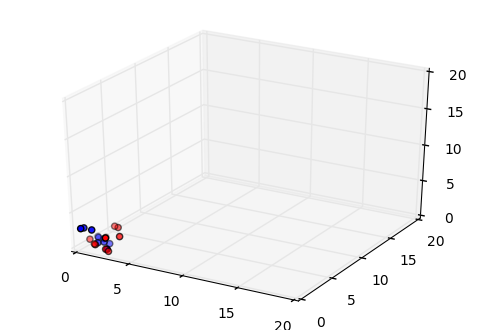

In [45]:
Repetitions = 10
particle_box = 3
boxsize = 20
n = 20
real-space-cutoff = 8.


x_Na = np.random.uniform(0, particle_box, int(n/2))
y_Na = np.random.uniform(0, particle_box, int(n/2))
z_Na = np.random.uniform(0, particle_box, int(n/2))
x_Cl = np.random.uniform(0, particle_box, int(n/2))
y_Cl = np.random.uniform(0, particle_box, int(n/2))
z_Cl = np.random.uniform(0, particle_box, int(n/2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_Na, y_Na, z_Na, c='r')
ax.scatter(x_Cl, y_Cl, z_Cl, c='b')
ax.set_xlim([0, boxsize])
ax.set_ylim([0, boxsize])
ax.set_zlim([0, boxsize])

## Random particle test for Coulomb-potential

In [46]:
print(test.test_coulomb_random())

None


## Random particle test for the different shortrange calculations

In [47]:
print(test.test_shortrange_with_different_neighbouring())

None


## Random particle test for Lennard-Jones potential

In [48]:
print(test.test_lennard_jones_rondom())

None
